In [1]:
PATH='/content/drive/MyDrive/Rohan/Final dataset/dataset_san_en.csv'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import string
from string import digits
import re
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
import codecs
import json

In [4]:
lines=pd.read_csv(PATH,encoding='utf-8')

In [5]:
lines.head(10)

,sanskrit,english
0,राजनेतानां कृते यत् कर्तव्यं तत् कर्तुं अनुमति...,politicians do not have permission to do what ...
1,एतादृशस्य एकस्य बालकस्य विषये अहं भवद्भ्यः वक्...,"I'd like to tell you about one such child,\n"
2,एतत् प्रतिशतं भारते यत् प्रतिशतं वर्तते तस्मात...,This percentage is even greater than the perce...
3,अस्माकं यत् वस्तुतः अभिप्रायः अस्ति तत् अस्ति ...,what we really mean is that they're bad at not...
4,.एतेषां वेदानां अन्त्यभागः उपनिषद् इति उच्यते।\n,.The ending portion of these Vedas is called U...
5,तत्कालीनः कश्मीरस्य राज्यपालः स्थानान्तरणस्य प...,The then Governor of Kashmir resisted transfer...
6,अस्मिन् भवतः पुरतः जनानां परिस्थितयः निहिताः स...,In this lies the circumstances of people befor...
7,"के च वयं वक्तुं, अपि, ते दोषिणः इति\n","And who are we to say, even, that they are wro..."
8,“”ग्लोबल वार्मिंग“” इति अन्तिमदशकेषु उत्पन्नं ...,“”Global Warming“” refer to warming caused in ...
9,भवान् इच्छति यत् भवतः बालकः एकं विद्यालयं गन्त...,You may want your child to go to a school that...


In [6]:
# Lowercase all characters
lines.english=lines.english.apply(lambda x: x.lower())
lines.sanskrit=lines.sanskrit.apply(lambda x: x.lower())

In [7]:
# Remove quotes
lines.english=lines.english.apply(lambda x: re.sub("'", '', x))
lines.sanskrit=lines.sanskrit.apply(lambda x: re.sub("'", '', x))

In [8]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.english=lines.english.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.sanskrit=lines.sanskrit.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [9]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.english=lines.english.apply(lambda x: x.translate(remove_digits))
lines.sanskrit = lines.sanskrit.apply(lambda x: re.sub("[२३०८१५७९४६1234567890]", "", x))

In [10]:
# Remove extra spaces
lines.english=lines.english.apply(lambda x: x.strip())
lines.sanskrit=lines.sanskrit.apply(lambda x: x.strip())
lines.english=lines.english.apply(lambda x: re.sub(" +", " ", x))
lines.sanskrit=lines.sanskrit.apply(lambda x: re.sub(" +", " ", x))

In [11]:
# Add start and end tokens to target sequences
lines.english = lines.english.apply(lambda x : 'START_ '+ x + ' _END')

In [12]:
lines.sample(10)

,sanskrit,english
9722,प्रथमः द्वितीयाय किञ्चित् दधिं दानं करोति द्वि...,START_ the first one donates some curds to the...
261,तमे वर्षे स्वातन्त्र्ययुद्धस्य अनन्तरं अण्डमान...,START_ after the war of independence the andam...
989,शोले बच्चनस्य विशालसफलतायाः अनन्तरं सः सशक्तः ...,START_ after the huge success of sholey baccha...
7572,वर्षपूर्वं एकः पुरुषः गृहीतवान्,START_ years ago it took one man _END
9126,कदाचित् एतादृशाः समस्याः सन्ति येषां विषये भवन...,START_ perhaps there are problems that you do ...
7248,कबीरस्य रामः धनिकदरिद्रयोः भेदात् परः अस्ति।,START_ kabirs ram is beyond the distinction of...
12729,प्रत्येकस्मिन् देशे वयं भिन्नप्रकारस्य विचाराः...,START_ in every country we find different type...
10306,iery कारखानाव्यवस्थायाः रेखासु न्यूनतया प्रतिर...,START_ iery was less patterned on the lines of...
3112,अकबरस्य शासनकालात् पूर्वं न्यायिकप्रक्रियाविषय...,START_ prior to akbar s reign traditional musl...
6061,बालकं बालकं वा पालयन्तः जनानां कृते,START_ for people bringing up a child or child...


In [13]:
all_eng_words=set()
for eng in lines.english:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_san_words=set()
for san in lines.sanskrit:
    for word in san.split():
        if word not in all_san_words:
            all_san_words.add(word)

In [14]:
# Max Length of source sequence
lenght_list=[]
for l in lines.sanskrit:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)

mean_length_src=np.mean(lenght_list)

In [15]:
# Max Length of target sequence
lenght_list=[]
for l in lines.english:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)

mean_length_tar=np.mean(lenght_list)

In [16]:
target_words = sorted(list(all_eng_words))
input_words = sorted(list(all_san_words))
num_decoder_tokens = len(all_eng_words)
num_encoder_tokens = len(all_san_words)
num_encoder_tokens, num_decoder_tokens

(6653, 5255)

In [17]:
num_decoder_tokens += 1
num_encoder_tokens += 1

In [18]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [19]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [20]:
# Train - Test Split
from sklearn.model_selection import train_test_split
X, y =  lines.sanskrit, lines.english
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((11610,), (1290,))

In [21]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [22]:
latent_dim = 50

In [23]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [24]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [25]:
from keras.models import load_model
model.load_weights('/content/drive/MyDrive/Rohan/Final dataset/small/weights/fin.h5')
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
#model=load_model('/content/drive/MyDrive/Rohan/Final dataset/small/fin.h5')

In [60]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 50)     332700      ['input_5[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 50)     262800      ['input_6[0][0]']                
                                                                                            

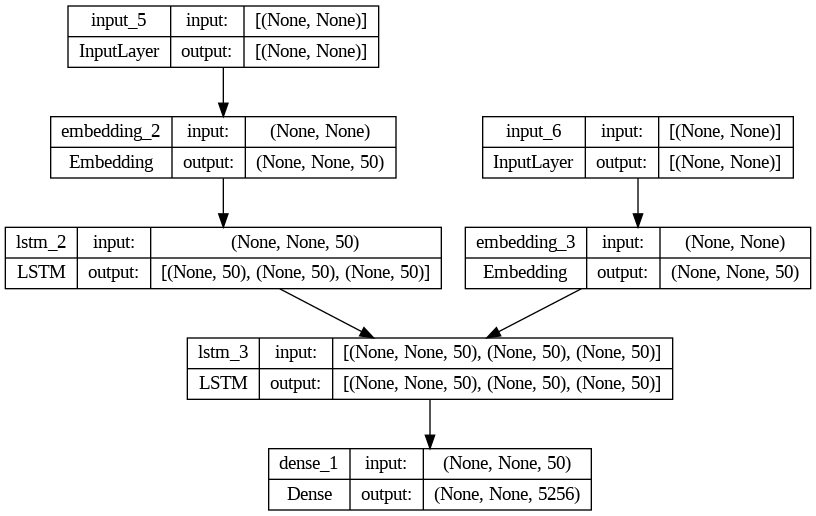

In [61]:

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [25]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 150

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

<ipython-input-27-b22c3ec5e69e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),


Epoch 1/150
90/90 [==============================] - 34s 251ms/step - loss: 1.0898 - acc: 0.0605 - val_loss: 1.0474 - val_acc: 0.0633
Epoch 2/150
90/90 [==============================] - 21s 228ms/step - loss: 1.0012 - acc: 0.0637 - val_loss: 1.0271 - val_acc: 0.0633
Epoch 3/150
90/90 [==============================] - 20s 226ms/step - loss: 0.9798 - acc: 0.0783 - val_loss: 1.0085 - val_acc: 0.0989
Epoch 4/150
90/90 [==============================] - 21s 231ms/step - loss: 0.9587 - acc: 0.1014 - val_loss: 0.9888 - val_acc: 0.1010
Epoch 5/150
90/90 [==============================] - 22s 243ms/step - loss: 0.9424 - acc: 0.1041 - val_loss: 0.9708 - val_acc: 0.1051
Epoch 6/150
90/90 [==============================] - 20s 225ms/step - loss: 0.9230 - acc: 0.1115 - val_loss: 0.9541 - val_acc: 0.1136
Epoch 7/150
90/90 [==============================] - 20s 224ms/step - loss: 0.9056 - acc: 0.1209 - val_loss: 0.9370 - val_acc: 0.1219
Epoch 8/150
90/90 [==============================] - 21s 230ms

In [ ]:
### saving model
model.save_weights('nmt_weights2.h5')

In [ ]:
model.save('/content/drive/MyDrive/Rohan/Final dataset/small/fin.h5')


In [ ]:
from keras.models import load_model

In [ ]:
model=load_model('/content/drive/MyDrive/Rohan/Final dataset/small/fin.h5')

In [ ]:
### Ploting epoch vs loss
'''plt.plot(range(len(model.history.history['val_loss'])),model.history.history['loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()'''

'plt.plot(range(len(model.history.history[\'val_loss\'])),model.history.history[\'loss\'])\nplt.xlabel("epochs")\nplt.ylabel("loss")\nplt.show()'

In [ ]:
### Ploting epoch vs accuracy
'''plt.plot(range(len(model.history.history['acc'])),model.history.history['acc'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()'''

'plt.plot(range(len(model.history.history[\'acc\'])),model.history.history[\'acc\'])\nplt.xlabel("epochs")\nplt.ylabel("accuracy")\nplt.show()'

In [26]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [27]:
def decode_sequence(input_seq,lenn):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > lenn*(mean_length_tar/mean_length_src)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [28]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1
res_out=np.array([['the sentence in engish','the sanskrit sentence','predicted translation']])

for k in range(1,5):

  (input_seq, actual_output), _ = next(val_gen)
  decoded_sentence = decode_sequence(input_seq,len(X_test[k-1:k].values[0])) 
  res_out=np.append(res_out,np.array([[y_test[k-1:k].values[0][7:-5],X_test[k-1:k].values[0],decoded_sentence[1:-5]]]),axis=0)

1/1 [==============================] - 0s 15ms/step


In [29]:
df=pd.DataFrame(res_out)

In [30]:
len(df)

5

In [31]:
df.head(10)

,0,1,2
0,the sentence in engish,the sanskrit sentence,predicted translation
1,the board estimated that about per cent of jap...,बोर्डेन अनुमानितम् यत् जापानीयानां आयातानां प्...,the board estimated that about per cent of jap...
2,this is opposite resources of push technology ...,इदं पुश प्रौद्योगिक्याः विपरीतसंसाधनम् अस्ति य...,this is opposite resources of push technology ...
3,they take three to four rounds of a fourkilome...,ते चतुर्किलोमीटर् व्यासस्य त्रीणि चत्वारि च गो...,they take three to four rounds of a fourkilome...
4,through the mammography we can also diagnose o...,स्तनचित्रणद्वारा वयं स्तनस्य अन्यसमस्याः अपि न...,through the mammography we can also diagnose o...


In [28]:
def get_input_data(sentence):
          encoder_input_data = np.zeros((1, max_length_src),dtype='float32')
          for t, word in enumerate(sentence.split()):
              encoder_input_data[0, t] = input_token_index[word] # encoder input seq
          return encoder_input_data,len(sentence)

In [29]:
def get_translation(sentence):
  input_seq,n=get_input_data(sentence)
  decoded_sentence = decode_sequence(input_seq,n)
  return decoded_sentence[1:-5]

In [30]:
sentence=input()
print(get_translation(sentence))



तस्य सम्पत्तिः जप्तवती
1/1 [==============================] - 0s 15ms/step
his property was confiscated
